In [2]:
import nbaPlayerStatModeling as nbaModel
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', 20)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column width

In [3]:
nba = nbaModel.playerStatModel(
        day_offset = 0, 
        season = '2024-25', 
        perMode = 'PerGame',
        num_simulations = 200000
)
nba.get_teams_playing()
nba.get_teams_data(
    base_url = 'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType={stattype}&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={sid}&SeasonSegment=&SeasonType=Regular%20Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
)

nba.get_players_playing(
    url_base_nba_player_stat = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode={per}&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={sid}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID={tid}&TwoWay=0&VsConference=&VsDivision=&Weight=',
    minute_cutoff = 10,
    season = '2025',
    pull_players_from_nbaapi = False
)
nba.get_props()

nba.get_player_home_adv(
    use_default=False,
    sleep_time = 3
)
nba.df_players = nba.df_players[(nba.df_players['FG3A'] > 0) & (nba.df_players['FTA'] > 0)]
df_copy = nba.df_players.copy()

8  games today...
222 players returned from 16 teams, out of a total 16
1050 prop bets for 107 players...


In [4]:
nba.df_players = df_copy.copy()
nba.model_expected_minutes()
nba.calculate_expected_stats()
nba.model_stats()

In [21]:
player = "Giannis Antetokounmpo"

In [22]:

reb = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'REB', 'expReb', 'reb_line', 'reb_oOdds', 'REBoOdds','REBoOdds_deci','REBoProb']]
reb['stat'] = 'reb'
ast = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'AST', 'expAst', 'ast_line', 'ast_oOdds', 'ASToOdds','ASToOdds_deci','ASToProb']]
ast['stat'] = 'ast'
pts = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'PTS', 'expPts', 'pts_line', 'pts_oOdds', 'PTSoOdds','PTSoOdds_deci','PTSoProb']]
pts['stat'] = 'pts'
fg3m = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'FG3M', 'expFG3M', 'threes_line', 'threes_oOdds', 'FG3MoOdds','FG3MoOdds_deci','FG3MoProb']]
fg3m['stat'] = 'fg3m'
pra = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'PRA', 'expPra', 'pra_line', 'pra_oOdds', 'PRAoOdds','PRAoOdds_deci','PRAoProb']]
pra['stat'] = 'pra'
pr = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'PR', 'expPr', 'pr_line', 'pr_oOdds', 'PRoOdds','PRoOdds_deci','PRoProb']]
pr['stat'] = 'pr'
pa = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'PA', 'expPa', 'pa_line', 'pa_oOdds', 'PAoOdds','PAoOdds_deci','PAoProb']]
pa['stat'] = 'pa'
ra = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'RA', 'expRa', 'ra_line', 'ra_oOdds', 'RAoOdds','RAoOdds_deci','RAoProb']]
ra['stat'] = 'ra'
stl = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'STL', 'expStl', 'stl_line', 'stl_oOdds', 'STLoOdds','STLoOdds_deci','STLoProb']]
stl['stat'] = 'stl'
blk = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'BLK', 'expBlk', 'blk_line', 'blk_oOdds', 'BLKoOdds','BLKoOdds_deci','BLKoProb']]
blk['stat'] = 'blk'
sb = nba.df_players[nba.df_players['PLAYER_NAME']==player][['PLAYER_NAME', 'SB', 'expSb', 'sb_line', 'sb_oOdds', 'SBoOdds','SBoOdds_deci','SBoProb']]
sb['stat'] = 'sb'

pts.columns = ['PLAYER_NAME', 'act', 'exp', 'line', 'ACToOdds', 'EXPoOdds', 'EXPoOdds_deci', 'EXPoProb', 'stat'] 
for i in [reb, ast, fg3m, pra, pr, pa, ra, stl, blk, sb ]:
    i.columns = ['PLAYER_NAME', 'act', 'exp', 'line', 'ACToOdds', 'EXPoOdds', 'EXPoOdds_deci', 'EXPoProb', 'stat']
    pts = pd.concat([pts, i])

odds = pts[['PLAYER_NAME', 'stat', 'act', 'exp', 'line', 'ACToOdds', 'EXPoOdds', 'EXPoOdds_deci', 'EXPoProb']].copy()
odds

,PLAYER_NAME,stat,act,exp,line,ACToOdds,EXPoOdds,EXPoOdds_deci,EXPoProb
22,Giannis Antetokounmpo,pts,30.566038,31.186282,31.5,-103.0,110.0,2.107,0.474655
22,Giannis Antetokounmpo,reb,12.264151,11.301691,12.5,-127.0,188.0,2.888,0.346300
22,Giannis Antetokounmpo,ast,5.943396,5.391222,6.5,100.0,236.0,3.368,0.296945
22,Giannis Antetokounmpo,fg3m,0.150943,0.183413,0.5,250.0,598.0,6.986,0.143135
22,Giannis Antetokounmpo,pra,48.773585,47.879195,50.5,-117.0,507.0,6.075,0.164615
22,Giannis Antetokounmpo,pr,42.830189,42.487974,44.0,-113.0,129.0,2.298,0.435250
22,Giannis Antetokounmpo,pa,36.509434,36.577504,37.5,-119.0,400.0,5.008,0.199665
22,Giannis Antetokounmpo,ra,18.207547,16.692913,19.5,-110.0,2633.0,27.337,0.036580
22,Giannis Antetokounmpo,stl,0.792453,0.711552,0.5,-163.0,-103.0,1.966,0.508720
22,Giannis Antetokounmpo,blk,1.226415,1.471259,0.5,-157.0,-335.0,1.298,0.770600


In [23]:
#nba.df_players.to_excel('test.xlsx')

# Scratch - Mean reversion

In [9]:
def adf_test(series):
    """Runs ADF test on a series and returns the p-value. If fewer than 6 games, return 1."""
    series = series.dropna()  # Ensure no NaNs
    if len(series) < 5:  # ADF requires at least a few lags, so set a safer threshold
        return 1  
    try:
        return round(adfuller(series)[1],4)  # Return p-value
    except ValueError:
        return 1  # If ADF still fails, return 1


def fit_ou_process(pts_series, mle=True):
    """Fits an Ornstein-Uhlenbeck process to a player's points time series."""
    pts_series = pts_series.dropna().values  # Remove NaNs
    if len(pts_series) < 2:
        return 1, np.mean(pts_series), np.std(pts_series)  # Default for small samples
    
    dt = 1  

    def ou_nll(params, X, dt):
        """Negative log-likelihood function for the OU process."""
        theta, mu, sigma = params
        if theta <= 0 or sigma <= 0:
            return np.inf  
        residuals = X[1:] - (X[:-1] * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt)))
        likelihoods = -0.5 * np.log(2 * np.pi * sigma**2 * (1 - np.exp(-2 * theta * dt)) / (2 * theta)) - (residuals**2) / (2 * sigma**2 * (1 - np.exp(-2 * theta * dt)) / (2 * theta))
        return -np.sum(likelihoods)

    if mle:
        result = minimize(ou_nll, x0=[0.1, np.mean(pts_series), np.std(pts_series)], args=(pts_series, dt), 
                          bounds=[(1e-5, None), (None, None), (1e-5, None)])
        return result.x if result.success else (1, np.mean(pts_series), np.std(pts_series))
    
    # LSR estimation
    X_t, dX = pts_series[:-1], np.diff(pts_series)
    
    if np.std(X_t) == 0:  # Prevent singular matrix error
        return 1, np.mean(pts_series), np.std(pts_series)
    
    try:
        beta, alpha = np.polyfit(X_t, dX, 1)
        theta, mu, sigma = -beta, alpha / -beta, np.std(dX - (beta * X_t + alpha)) / np.sqrt(2 * -beta)
    except np.linalg.LinAlgError:
        return 1, np.mean(pts_series), np.std(pts_series)  # Return defaults on failure

    return round(theta, 2), round(mu, 2), round(sigma, 2)

def process_players(df, stat, mle=True):
    """Runs ADF test and fits OU process for each player on the specified stat."""
    results = []
    
    for player, group in df.groupby('PLAYER_NAME'):
        series = group[stat]
        adf_pval = adf_test(series)
        
        if adf_pval < 0.05:
            theta, mu, sigma = fit_ou_process(series, mle=mle)
            tau = 1/theta
        else:
            theta, tau, mu, sigma = 1, 1, 1, 1 
        
        results.append({'PLAYER_NAME': player, 'ADF_PVALUE': adf_pval, 'THETA': theta, 'TAU':tau, 'MU': mu, 'SIGMA': sigma})
    
    return pd.DataFrame(results)

# Example usage:
df_results = process_players(nba.df_player_boxscores, 'PTS', mle=False)


c:\Users\jrbrz\.virtualenvs\propfarm-_NXI0yZr\lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [10]:
df_results.describe()


,ADF_PVALUE,THETA,TAU,MU,SIGMA
count,349.000000,349.000000,349.000000,349.000000,349.000000
mean,0.212677,0.983725,1.041065,6.859599,2.750057
std,0.365578,0.153077,0.166711,7.004111,1.728507
min,0.000000,0.560000,0.534759,0.300000,0.270000
25%,0.000000,0.920000,0.990099,1.000000,1.000000
50%,0.000600,1.000000,1.000000,4.100000,2.710000
75%,0.222300,1.010000,1.086957,10.430000,4.070000
max,1.000000,1.870000,1.785714,29.470000,6.930000


In [26]:
df_results

,PLAYER_NAME,ADF_PVALUE,THETA,TAU,MU,SIGMA
0,A.J. Lawson,0.2866,1.00,1.000000,1.00,1.00
1,Aaron Gordon,0.0000,0.99,1.010101,4.89,2.07
2,Aaron Nesmith,0.9991,1.00,1.000000,1.00,1.00
3,Aaron Wiggins,0.0000,1.10,0.909091,3.79,1.72
4,Adam Flagler,0.0000,1.10,0.909091,0.36,0.43
5,Adama Sanogo,1.0000,1.00,1.000000,1.00,1.00
6,Ajay Mitchell,0.0000,1.04,0.961538,2.00,1.50
7,Al Horford,0.0000,0.87,1.149425,5.64,1.67
8,Alec Burks,0.0002,0.74,1.351351,2.68,1.97
9,Alex Caruso,0.0000,1.10,0.909091,2.74,1.00


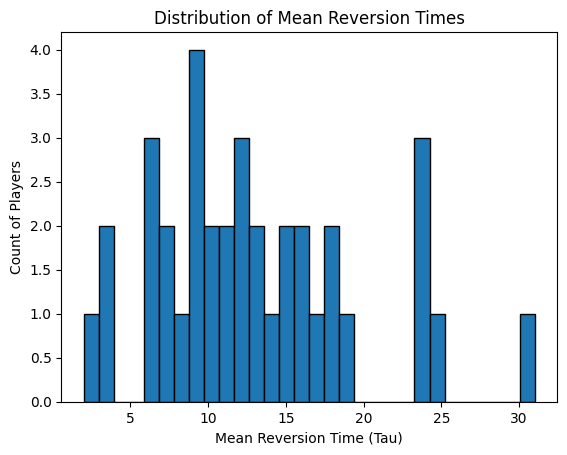

In [37]:
import matplotlib.pyplot as plt

plt.hist(nba.df_player_boxscores[
    nba.df_player_boxscores['PLAYER_NAME']=='Aaron Gordon'
]['PTS'], bins=30, edgecolor='black')
plt.xlabel("Mean Reversion Time (Tau)")
plt.ylabel("Count of Players")
plt.title("Distribution of Mean Reversion Times")
plt.show()



In [33]:
pts_cols = []
for i in nba.df_players.columns:
    if  'line' in i.lower():
        pts_cols.append(i)

#nba.df_players[pts_cols]
pts_cols

['threes_line',
 'stl_line',
 'reb_line',
 'ra_line',
 'pts_line',
 'pra_line',
 'pr_line',
 'pa_line',
 'blk_line',
 'ast_line',
 'sb_line']